# Analyzing Natality Data Using Vertex AI and BigQuery

In this lab, you analyze a large (137 million rows) natality dataset using BigQuery and Vertex AI.

This lab illustrates how you can carry out data exploration of large datasets, but continue to use familiar tools like Pandas and Jupyter. The trick is to do the first part of your aggregation in BigQuery, get back a Pandas DataFrame, then work with the smaller Pandas DataFrame locally. Vertex AI provides a managed Jupyter experience, so you don't need to run notebook servers yourself.

## Objectives

* Launch Vertex AI notebook.
* Invoke a BigQuery query.
* Create charts in Jupyter.
* Export data for machine learning.

You can access the lab at [here](https://www.cloudskillsboost.google/focuses/604?parent=catalog).

# Invoke BigQuery

In BigQuery console, we will query the number of `plurality` from the US Natality Data Set.

```sql
SELECT 
    plurality,
    COUNT(1) AS num_babies,  -- For every plurality, add (1).
    AVG(weight_pounds) AS ave_weight
FROM `bigquery-public-data.samples.natality` WHERE year > 2000 AND year < 2005
GROUP BY plurality
```

![](https://media.discordapp.net/attachments/984655726406402088/993691287389749288/unknown.png)

Review the result. How many triplets were born in the US between 2000 and 2005? *There are **27697 triplets** between 2000 and 2005.*

# Visualize Data in Vertex AI

We will start by updating to the latest version of the BigQuery Python Client Library.

In [1]:
!pip install google-cloud-bigquery==1.25.0
!pip install --upgrade google-cloud-bigquery-storage

Then, restart the kernel.

After the kernel has restarted, we will import the BigQuery Python Client Library and initialize a client. The BigQuery client will be used to send and receive messages from the BigQuery API.

In [1]:
from google.cloud import bigquery
client = bigquery.Client()

Now we will run a query on the BigQuery Natality Public Data Set:

In [2]:
sql = """
  SELECT
      plurality,
      COUNT(1) AS count,
      year
  FROM `bigquery-public-data.samples.natality`
  WHERE NOT IS_NAN(plurality) AND plurality > 1
  GROUP BY plurality, year ORDER BY count DESC
"""
df = client.query(sql).to_dataframe()

df.head()

,plurality,count,year
0,2,139209,2007
1,2,138866,2008
2,2,137239,2006
3,2,133285,2005
4,2,132344,2004


This dataset describes all United States births registered from 1969 to 2008. This query returns the annual count of plural births by plurality (2 for twins, 3 for triplets, etc.). The head of the DataFrame (the first 5 rows) is displayed below the code cell. Full results are available for further analysis in a Pandas DataFrame.

Now, we will pivot the data and create a stacked bar chart of the count of plural births over time:

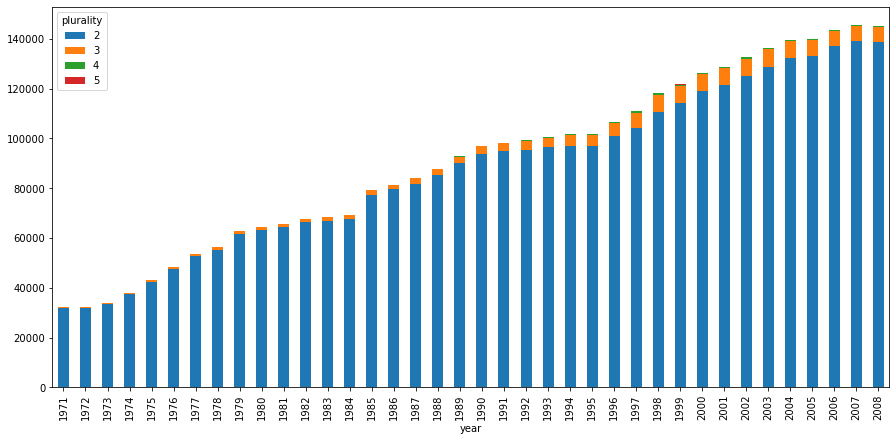

In [3]:
pivot_table = df.pivot(index='year', columns='plurality', values='count')
pivot_table.plot(kind='bar', stacked=True, figsize=(15,7));

Next, take a look at baby weight by gender:

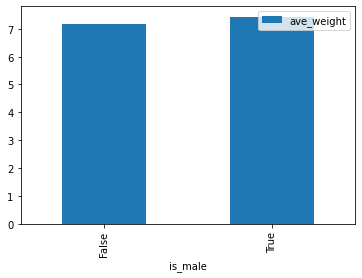

In [4]:
sql = 'SELECT is_male, AVG(weight_pounds) AS ave_weight FROM `bigquery-public-data.samples.natality` GROUP BY is_male'
df = client.query(sql).to_dataframe()

df.plot(x='is_male', y='ave_weight', kind='bar');

Are male babies heavier or lighter than female babies? *Based on the bar chart, male babies* (`is_male = true`) *are have slightly larger average weight* (`ave_weight`)*, so male babies are slightly heavier.*

Now, we will see how the baby's weight fluctuates according to the number of [gestation weeks](https://www.verywellfamily.com/gestational-age-2371620).

> **Note:**<br>Because the `gestation_weeks` field allows null values and stores unknown values as `99`, this query excludes records where `gestation_weeks` is `null` or `99`.

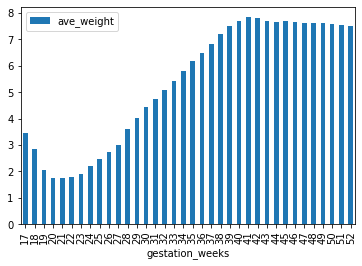

In [5]:
sql = """
    SELECT gestation_weeks, AVG(weight_pounds) AS ave_weight
    FROM `bigquery-public-data.samples.natality`
    WHERE NOT IS_NAN(gestation_weeks) AND gestation_weeks <> 99
    GROUP BY gestation_weeks ORDER BY gestation_weeks
"""
df = client.query(sql).to_dataframe()

df.plot(x='gestation_weeks', y='ave_weight', kind='bar');